In [1]:
import mlflow
from mlflow.models import infer_signature
import tempfile
import numpy as np
import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error
from encdec_ad_tensorflow.plots import plot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import os
import math
from sklearn.cluster import KMeans
from sklearn.metrics import precision_score
import seaborn as sns
from sklearn import metrics
import time
import pickle
import metric_learn
from sklearn.decomposition import PCA  
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import LocalOutlierFactor
import functools
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from encdec_ad_tensorflow.model import EncoderDecoder
from sklearn.metrics import fbeta_score
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.list_physical_devices('GPU')
from utils import make_data, make_data_rev, make_label, calc_leq, leq_filter, validate, figure, figure_detail, plot_timeseries, fig_pr, auc_gs, fig_th_f

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13711457953220013131
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1152157012
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17942120079439668808
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2165803540361994214
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1152157012
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6530112950378552579
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
data_dir='filtered_csv_label'
original = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df = pd.read_csv( os.path.join(data_dir, 'learning_data_10.csv') )
df=df[df['day']<=9]
df

original  label  time  day
0            53.4      0    15    0
1            52.8      0    15    0
2            52.8      0    15    0
3            53.2      0    15    0
4            53.6      0    15    0
...           ...    ...   ...  ...
3995345      45.9      0     5    9
3995346      45.6      0     5    9
3995347      45.8      0     5    9
3995348      45.7      0     5    9
3995349      45.9      0     5    9

[3995350 rows x 4 columns]

# ホールドアウト検証
## 訓練、テストへ分割
* テスト（最終評価用）：6, 7, 8, 9 日目
---
ラベル付け
* 全体：0, 1, 2, 3, 4, 5 日目
* 訓練ローテ：(訓練、ラベル付与対象)=([0, 1, 2, 3, 4], 5)・・・([5, 0, 1, 2, 3], 4)

In [3]:
test_day=[6, 7, 8, 9]
semi_train_day=[0, 1, 2, 3, 4, 5]

test_df=df[(df['day'].isin(test_day))].reset_index(drop=True)
semi_train_df=df[(df['day'].isin(semi_train_day))].reset_index(drop=True)

In [4]:
df_list=[]

window_size=5
for i in set(df['day']):
    lag=[] 
    lag.append(make_data(semi_train_df.loc[semi_train_df['day']==i, ['original']], 'original', window_size))
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['day']])
    lag.append(semi_train_df.loc[semi_train_df['day']==i, ['label']])
    df_add_lag=pd.concat(lag, axis=1)
    df_list.append(df_add_lag)
semi_train_df=pd.concat(df_list)
semi_train_df=semi_train_df.dropna().reset_index(drop=True)
semi_train_df.loc[:, 'd']=0

In [5]:
semi_train_df

original  original_lag1  original_lag2  original_lag3  original_lag4  \
0            53.6           53.2           52.8           52.8           53.4   
1            54.0           53.6           53.2           52.8           52.8   
2            54.7           54.0           53.6           53.2           52.8   
3            55.7           54.7           54.0           53.6           53.2   
4            55.5           55.7           54.7           54.0           53.6   
...           ...            ...            ...            ...            ...   
2393381      45.0           45.4           45.1           44.8           45.4   
2393382      45.2           45.0           45.4           45.1           44.8   
2393383      45.1           45.2           45.0           45.4           45.1   
2393384      45.1           45.1           45.2           45.0           45.4   
2393385      46.0           45.1           45.1           45.2           45.0   

         day  label  d  
0          0      0  0  
1          0      0  0  
2          0      0  0  
3          0      0  0  
4          0      0  0  
...      ...    ... ..  
2393381    5      0  0  
2393382    5      0  0  
2393383    5      0  0  
2393384    5      0  0  
2393385    5      0  0  

[2393386 rows x 8 columns]

## 訓練

2023/12/30 00:18:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2023/12/30 00:18:53 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/12/30 00:18:53 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



訓練データ：[0, 2, 3, 4, 5]
ラベル付与データ：[1]日目


2023/12/30 00:18:53 WARNING mlflow.tensorflow: Encountered unexpected error while inferring batch size from training dataset: The layer "encoder_decoder" has never been called and thus has no defined input shape. Note that the `input_shape` property is only available for Functional and Sequential models.
2023/12/30 00:18:54 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\Arakawa\anaconda3\envs\tf291\lib\site-packages\mlflow\tensorflow\_autolog.py:52: UserWarning: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data."


4114/4114 [==============================] - 80s 18ms/step - loss: 8.5466e-04 - val_loss: 0.0083
------------------------------------------------------


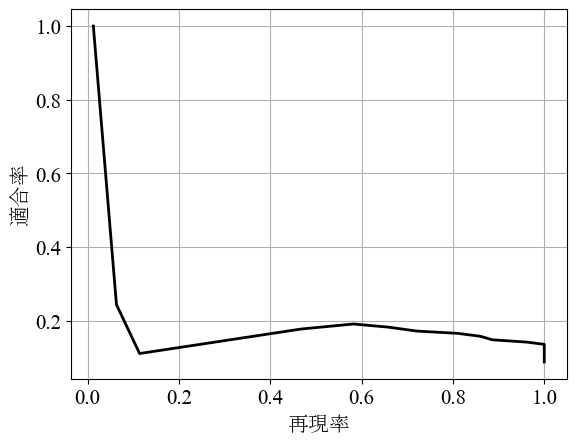

AUC：0.18124395994650153
理想の閾値：0.56
F値（最高）：0.2876847952880615
適合率（F値が最高の時）：0.19103430575754984
再現率（F値が最高の時）：0.5822784810126582
C:\Users\Arakawa\AppData\Local\Temp\tmp2z0nr3rk\predict_results.png


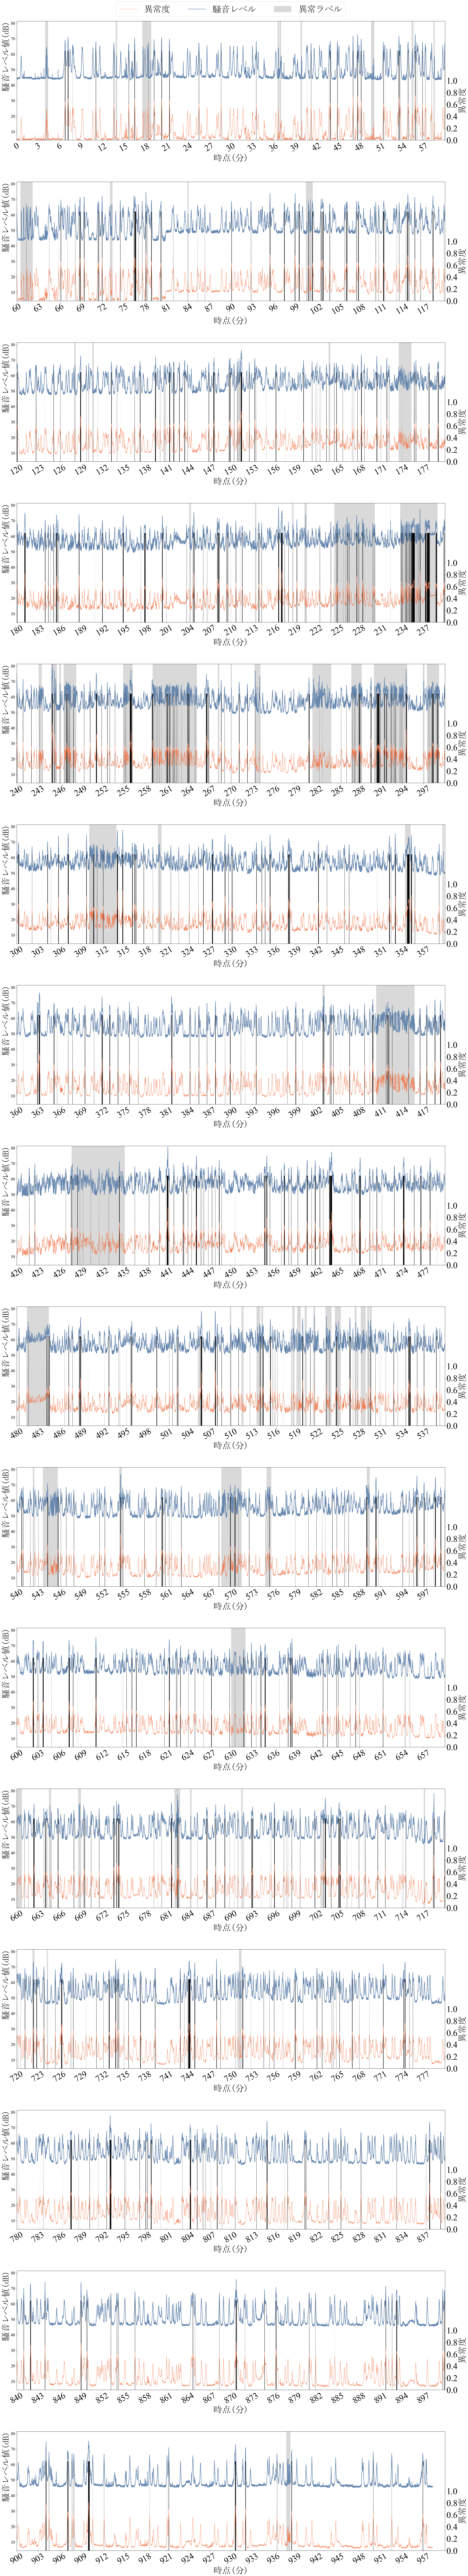

In [6]:
mlflow.autolog(log_models=False)

# 実験をアクティブ化(設定)する。ない場合は新たな実験を作成してアクティブ化する
mlflow.set_experiment("architecture")
run_name='architecture'
with mlflow.start_run(run_name=run_name):


    # テストデータとする日
    i=[1]
    label_train_day=[k for k in semi_train_day if k not in i]
    label_grant_day=i
    print(f'訓練データ：{label_train_day}')
    print(f'ラベル付与データ：{label_grant_day}日目')
    # Log the hyperparameters
    mlflow.log_params({'trainday':label_train_day, 'testday':label_grant_day})
    

    # 訓練データ前処理
    semi_train_x=semi_train_df[(semi_train_df['day'].isin(label_train_day))][semi_train_df.columns[:-3]].reset_index(drop=True)
    labeling_x=semi_train_df[(semi_train_df['day'].isin(label_grant_day))][semi_train_df.columns[:-3]].reset_index(drop=True)
    # tf.reduce_min関数を使用して、train_dataテンソル内の最小値を計算しています。
    # min_valにはtrain_data内の最小値が代入されます。
    min_val = tf.reduce_min(semi_train_x)
    # tf.reduce_max関数を使用して、train_dataテンソル内の最大値を計算しています。
    # max_valにはtrain_data内の最大値が代入されます。
    max_val = tf.reduce_max(semi_train_x)
    # 正規化
    train_data = (semi_train_x - min_val) / (max_val - min_val)
    labeling_data = (labeling_x - min_val) / (max_val - min_val)

    # データをモデルに入力する形状に整形し，型をtf.float32に変換
    train_data = tf.cast(train_data.values[:, :, np.newaxis], tf.float32)
    # テストデータ前処理
    labeling_data = tf.cast(labeling_data.values[:, :, np.newaxis], tf.float32)
    # テストデータセットを作成し、メモリの都合上バッチに分割
    test_batch = 2048  
    test_ds = tf.data.Dataset.from_tensor_slices(labeling_data).batch(test_batch)

    # モデル訓練
    c=64      # Number of hidden units.
    d=0.3     # Dropout rate.
    learning_rate=0.001
    early_stopping_patience=10
    max_epochs=1

    model = EncoderDecoder(
        L=window_size,  # input length
        m=1,  # Number of time series.
        c=c,  # hidden size
        d=d   # dropout rate
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError()
    )
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=early_stopping_patience,
        restore_best_weights=True
    )

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    history = model.fit(train_data, train_data,
        epochs=max_epochs,
        batch_size=512,
        validation_data=(labeling_data, labeling_data),
        callbacks=[tensorboard_callback],
    )

    # バッチ処理で予測を行う
    predictions = []
    for test_x in test_ds:
        batch_predictions = model(test_x, training=False)
        predictions.extend(batch_predictions.numpy().tolist())

    predictions=np.array(predictions)
    error= tf.keras.losses.mae(predictions.reshape(predictions.shape[0], predictions.shape[1]), 
                           labeling_data.numpy().reshape(labeling_data.shape[0], labeling_data.shape[1])).numpy()

    semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), 'seqd']=error
    print('------------------------------------------------------')
    
    test_v=semi_train_df.loc[semi_train_df['day'].isin(label_grant_day), ['original', 'label']].copy().reset_index(drop=True)

    d_test=(error-error.min())/(error.max()-error.min())
    
    thr_bins=20
    p_score, r_score, f_score, thresholds, thr, auc = fig_pr(test_v, d_test, thr_bins)
    f_max=f_score.max()
    p_max=p_score[np.argmax(f_score)]
    r_max=r_score[np.argmax(f_score)]
    print('\033[31m'+f'AUC：{auc}'+'\033[0m')
    print(f'理想の閾値：{thr}')
    print(f'F値（最高）：{f_max}')
    print(f'適合率（F値が最高の時）：{p_max}')
    print(f'再現率（F値が最高の時）：{r_max}')
    
    # Log the loss metric
    mlflow.log_metric("test_AUC", auc)
    mlflow.log_metric("test_Fscore_best", f_max)
    mlflow.log_metric("test_Precision_when Fscore Best", p_max)
    mlflow.log_metric("test_Recall_when Fscore Best", r_max)
    
    # 一時ディレクトリに予測結果のグラフを保存して，mlflowに送信する
    with tempfile.TemporaryDirectory()  as tmp:
        filename = os.path.join(tmp, "predict_results.png")
        plot_timeseries([test_v['original'].values], test_v['label'].values, d=d_test, thr=thr, mlflow=filename)
        mlflow.log_artifact(filename, artifact_path="plot_timeseries")
    
#     モデルの構造を定義しているソースコードを保存
    mlflow.log_artifact('encdec_ad_tensorflow/model.py', artifact_path="source_code")
    mlflow.log_artifact('encdec_ad_HO.ipynb', artifact_path="source_code") 
    

In [ ]:
! mlflow ui --port 5003 